# Improving a Machine Learning model

* First predictions = **Baseline predictions.**
* First model = **Baseline model.**

From a **data** perspective:
* Could we collect more data? 
* Could we improve our data?

From a **model** perspective:
* Is there a better model we could use? (see scikit-learn model flow chart)
* Could we improve the current model?

Hyperparameters vs Parameters
* **Parameters** = The model finds these patterns in data.
* **Hyperparameters** = Settings on a model, that you adjust to (potentially) improve its ability to find patterns.

Three ways to adjust Hyperparameters:
* By hand
* Randomly with RandomSearchCV
* Exhaustively with GridSearchCV

In [1]:
# Standard imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Load data

from sklearn.datasets import load_boston

boston = load_boston()

boston_df = pd.DataFrame(boston['data'], columns=boston['feature_names'])
boston_df['target'] = pd.Series(boston['target'])


heart_disease = pd.read_csv('~/sample_project/Data/heart-disease.csv')

In [3]:
# Specific imports 

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

**Improving the model**

In [4]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

In [5]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### 5.1 Tuning hyperparameters by hand

Make 3 sets: 
* Training.
* Validation.
* Test

In [6]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

We will try to adjust the following:
* `max-depth`.
* `max_features`.
* `min_samples_leaf`.
* `min_samples_split`.
* `n_estimators`.

In [7]:
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true vs. y_pred labels, on a classification model.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

#### Manually splittiing the data.

###### Shuffling the data.

In [8]:
np.random.seed(42)

heart_disease_shuffled = heart_disease.sample(frac=1)

###### Split into X and y.

In [9]:
X = heart_disease_shuffled.drop('target', axis=1)
y = heart_disease_shuffled['target']

###### Split the data into train, validation and test sets.

In [10]:
train_split = round(0.7 * len(heart_disease_shuffled))
validation_split = round(train_split + 0.15 * len(heart_disease_shuffled))

X_train, y_train = X[:train_split], y[:train_split]

X_valid, y_valid = X[train_split:validation_split], y[train_split:validation_split]

X_test, y_test = X[validation_split:], y[validation_split:]

In [11]:
len(X_train), len(X_valid), len(X_test)

(212, 45, 46)

In [12]:
clf = RandomForestClassifier()

**baseline parameters**

In [13]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [14]:
clf.fit(X_train, y_train)

# Make baseline predictions, on the valid set. As this is what we will be tuning the hyperparameters on.

y_preds = clf.predict(X_valid)

# Evaluate the classifier on valid set

baseline_metrics = evaluate_preds(y_valid, y_preds)
baseline_metrics

Accuracy: 82.22%
Precision: 0.81
recall: 0.88
F1 score: 0.85


{'accuracy': 0.82, 'precision': 0.81, 'recall': 0.88, 'f1': 0.85}

**Create a second classifier, with different hyperparameters**

In [18]:
clf_2 = RandomForestClassifier(max_depth=10,
                               max_features=10)
clf_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=10)

Make predictions with different hyperparameters

In [19]:
y_preds_2 = clf_2.predict(X_valid)

Evaluate the 2nd hyperparameter

In [20]:
clf_2.metrics = evaluate_preds(y_valid, y_preds_2)


Accuracy: 80.00%
Precision: 0.81
recall: 0.84
F1 score: 0.82


### 5.2 Hyperparameters tuning with RandomizedSearchCV

In [22]:
from sklearn.model_selection import RandomizedSearchCV

grid = {'n_estimators': [10, 100, 200, 500, 1000, 1200],
        'max_depth': [None, 5, 10, 20, 30],
        'max_features': ["auto", "sqrt"],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 2, 4]}

np.random.seed(42)

# Split into X and y

X = heart_disease_shuffled.drop('target', axis=1)
y = heart_disease_shuffled['target']

# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Instantiate RandomForestClassifier

clf = RandomForestClassifier(n_jobs=1)

# Set up RandomizedSearchCV

rs_clf = RandomizedSearchCV(estimator=clf, 
                            param_distributions=grid,
                            n_iter=10, #number of models to try
                            cv=5, 
                            verbose=2)

Fit the RandomizedSearchCV version of clf

In [24]:
rs_clf.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   0.3s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200

In [25]:
rs_clf.best_params_

{'n_estimators': 500,
 'min_samples_split': 6,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 5}

Make predictions with the best hyperparameters

In [26]:
rs_y_preds = rs_clf.predict(X_test)

Evaluate the predictions

In [27]:
rs_metrics = evaluate_preds(y_test, rs_y_preds)

Accuracy: 85.25%
Precision: 0.79
recall: 0.93
F1 score: 0.85


### 5.3 Hyperparameters tuning with GridSearchCV

In [28]:
grid

{'n_estimators': [10, 100, 200, 500, 1000, 1200],
 'max_depth': [None, 5, 10, 20, 30],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [2, 4, 6],
 'min_samples_leaf': [1, 2, 4]}

**Check best params and work the next grids params on that.**

Otherwise we will be building 6x5x2x3x3x5 (2700) models.
With grid_2, we build 3x1x2x1x2x5 (60) models.

In [29]:
grid_2 = {'n_estimators': [100, 200, 500],
          'max_depth': [None],
          'max_features': ['auto', 'sqrt'],
          'min_samples_split': [6],
          'min_samples_leaf': [1, 2]}

In [32]:
from sklearn.model_selection import GridSearchCV, train_test_split

np.random.seed(42)

# Split into X and y

X = heart_disease_shuffled.drop('target', axis=1)
y = heart_disease_shuffled['target']

# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Instantiate RandomForestClassifier

clf = RandomForestClassifier(n_jobs=1)

# Set up GridSearchCV

gs_clf = GridSearchCV(estimator=clf, 
                            param_grid=grid_2,
                            cv=5, 
                            verbose=2)

# Fit the GridSearchCV version of clf

gs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, 

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=1),
             param_grid={'max_depth': [None], 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2], 'min_samples_split': [6],
                         'n_estimators': [100, 200, 500]},
             verbose=2)

In [33]:
gs_clf.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 200}

In [34]:
gs_y_preds = gs_clf.predict(X_test)


Evaluate the predictions

In [35]:
gs_metrics = evaluate_preds(y_test, gs_y_preds)

Accuracy: 78.69%
Precision: 0.74
recall: 0.82
F1 score: 0.78


Compare different model's metrics

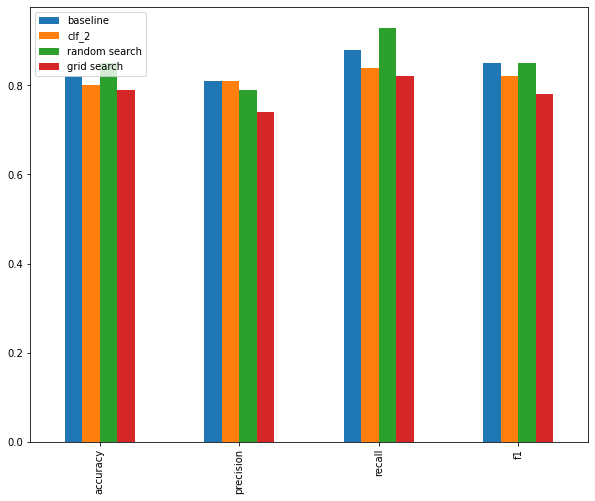

In [39]:
compare_metrics = pd.DataFrame({'baseline': baseline_metrics,
                                'clf_2': clf_2.metrics,
                                'random search': rs_metrics,
                                'grid search': gs_metrics
                                })

compare_metrics.plot.bar(figsize=(10,8));

**As always, when comparing models, you should be careful to make sure they're compared on the same splits of data.**